# A simple notebook to do MIRI coordinate transforms. #

Some functionality depends on having the JWST pipeline and/or pysiaf module installed

In [1]:
import numpy as np
import pdb as pdb
from astropy.modeling import models
from asdf import AsdfFile
from jwst import datamodels
from jwst.assign_wcs import miri
import pysiaf

### Imager transforms using standalone code plus pysiaf ###

Import the miricoord standalone code:

In [2]:
import miricoord.imager.mirim_tools as mt

Read the MIRI apertures from the SIAF

In [3]:
siaf = pysiaf.Siaf('MIRI')#,basepath='/Users/dlaw/jwcode/pysiaf/pysiaf/pre_delivery_data/MIRI')

Get the MIRIM_FULL x,y reference location from the SIAF

In [4]:
xref,yref=siaf['MIRIM_FULL'].XDetRef,siaf['MIRIM_FULL'].YDetRef

Note that these are in the SIAF 1-indexed reference frame; in order to use them we'll first have to transform them to the 0-indexed frame used by all MIRI coordinates code (and the JWST pipeline):

In [5]:
xref,yref=xref-1,yref-1

In [6]:
xref,yref

(692.5, 511.5)

Transform them to v2,v3 for filter 'F770W'

In [7]:
v2ref,v3ref=mt.xytov2v3(xref,yref,'F770W')

In [8]:
v2ref,v3ref

(array([-453.55911607]), array([-373.81444687]))

This should be showing that the v2,v3 reference point of MIRIM_FULL (for which F770W is the reference filter) is -453.559, -373.814 (note that this changed in CDP-7)

We can also convert a given location to RA,DEC if we assume a few JWST attitude keywords.  First import the miricoord telescope tools module:

In [9]:
import miricoord.tel.tel_tools as teltools

Let's pretend that the telescope pointing had the reference point looking at RA=312.5, DEC=-76.0, and had spacecraft roll 73 degrees

In [10]:
raref,decref,rollref=312.5,-76.0,73.0

Given that, we want to know where the location v2,v3=(-400,-420) is (this is somewhere in the coronagraphs):

In [11]:
v2,v3=[-400.],[-420.]

In [12]:
ra,dec,newroll=teltools.jwst_v2v3toradec(v2,v3,v2ref=v2ref,v3ref=v3ref,raref=raref,decref=decref,rollref=rollref)

The RA,dec of this point is:

In [13]:
ra,dec

(array([312.46722512]), array([-76.01797616]))

And the local roll at this new location is:

In [14]:
newroll

array([73.0318312])

Note that if we instead had a FITS header with the appropriate keywords, we could have passed that to jwst_v2v3toradec instead of individual values.

### Now let's do an imager transform using the JWST pipeline code ###

Import the miricoord pipeline access code:

In [15]:
import miricoord.imager.mirim_pipetools as mpt

In [16]:
v2ref,v3ref=mpt.xytov2v3(xref,yref,'F770W')

In [17]:
v2ref,v3ref

(-453.5591160661637, -373.81444687292515)

This should be the same answer as before, but under the hood it used the JWST pipeline!

We can also access the pipeline distortion model directly:

In [18]:
model=mpt.xytov2v3model('F770W')

And use that to do forward transforms:

In [19]:
model(xref,yref)

(-453.5591160661637, -373.81444687292515)

And backward transforms:

In [20]:
model.inverse(v2ref,v3ref)

(692.5025291563256, 511.48859557073246)

### Now do a conversion to Ideal coordinates using the SIAF apertures: ###

Let's work out where v2,v3=-415.069, -400.576 is for the LRS slit

In [21]:
v2,v3=-415.069, -400.576

In [22]:
xideal,yideal=mt.v2v3toIdeal(v2,v3,'MIRIM_SLIT')

SIAF version:  PRDOPSSOC-031


In [23]:
xideal,yideal

(0.0, 0.0)

It's 0,0, which makes sense since this was the MIRIM_SLIT reference point.

Now see what the lower-left corner of the LRS slit corresponds to in the SIAF:

In [24]:
xideal,yideal=siaf['MIRIM_SLIT'].XIdlVert1,siaf['MIRIM_SLIT'].YIdlVert1

In [25]:
v2,v3=mt.Idealtov2v3(xideal,yideal,'MIRIM_SLIT')

SIAF version:  PRDOPSSOC-031


In [26]:
xideal,yideal,v2,v3

(-2.3632, -0.2588, -412.73503327112616, -401.02798560652946)

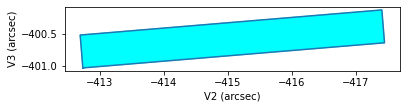

In [27]:
siaf['MIRIM_SLIT'].plot()

As another example, APT requires Ideal coordinate offsets from the reference point

If we wanted to see where an offset of XIdeal,YIdeal=10,0 in filter F2300C would land a star on the imager detector compared to the nominal Lyot coronagraph reference point in F770W:

In [28]:
xideal,yideal=10,0

In [29]:
v2,v3=mt.Idealtov2v3(xideal,yideal,'MIRIM_CORONLYOT')

SIAF version:  PRDOPSSOC-031


In [30]:
x,y=mt.v2v3toxy(v2,v3,'F2300C')

In [31]:
print(x,y)

[231.28115409] [885.2137205]


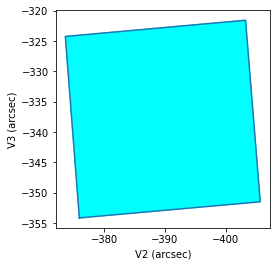

In [32]:
siaf['MIRIM_CORONLYOT'].plot()

### Now we'll do an MRS transform using standalone code plus pysiaf ###

In [33]:
import miricoord.mrs.mrs_tools as mrst

Get the MRS v2,v3 reference point from the SIAF

In [34]:
v2ref,v3ref=siaf['MIRIFU_CHANNEL1A'].V2Ref,siaf['MIRIFU_CHANNEL1A'].V3Ref

In [35]:
v2ref,v3ref

(-503.6545, -318.7425)

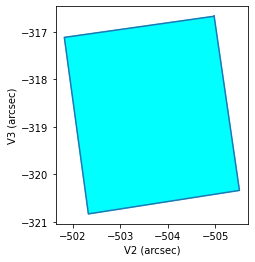

In [36]:
siaf['MIRIFU_CHANNEL1A'].plot()

Figure out what alpha,beta this is in Channel 1A

In [37]:
alpha,beta=mrst.v2v3toab(v2ref,v3ref,'1A')

In [38]:
alpha,beta

(0.00021318721945817742, 0.0003681314927916901)

By design, it's zero,zero since this was the reference point

Now find out where pixels 50,60 55,60 and 60,60 on the SHORT detector would be for Ch1A

In [39]:
x,y=[50,55,60],[60,60,60]

In [40]:
temp=mrst.xytoabl(x,y,'1A',trim=1)

In [41]:
temp

{'x': array([50, 55]),
 'y': array([60, 60]),
 'alpha': array([0.18518973, 1.08243462]),
 'beta': array([1.77210144, 1.77210144]),
 'lam': array([4.92912834, 4.92944324]),
 'slicenum': array([21, 21]),
 'slicename': array(['121A', '121A'], dtype='<U4')}

Note that here the return is actually a dictionary of information, and that it is only 2 elements long.  This is because we specified trim=1, which will remove any values that do not correspond to a light-sensitive slice.

In [42]:
v2,v3=mrst.abtov2v3(temp['alpha'],temp['beta'],'1A')

In [43]:
v2,v3

(array([-503.71851691, -502.82966055]), array([-320.52955204, -320.66752684]))

### Now we'll do an MRS transform using the pipeline code ###

In [44]:
import miricoord.mrs.mrs_pipetools as mrspt

In [45]:
x,y=30.31,511.0

In [46]:
a,b,l=mrspt.xytoabl(x,y,'1A')

In [47]:
print(a,b,l)

0.4612954052724527 0.0 5.343680519509376


Be warned: using the pipeline code in this way can give strange results if you try to transform a pixel that doesn't land on a slice in your channel specified!!  (The pipeline itself has code elsewhere to deal with this, but here we're hooking directly into the transform modules).